## Data analysis activity: revisiting Galton's height study

### Summary and goals

The goal of this activity is to redo Galton’s analysis of human height data as collaboratively as possible: we will try to rediscover his findings and examine how robust they are. We will measure the regression-to-the-mean relation:

$$
\langle y_c\rangle = \frac{2}{3} \langle y_p\rangle
$$

where we define the deviation variable as:

$$
y = h - \hat{\mu}
$$

with $h$ being height and $\hat{\mu}$ being the empirical mean height of the reference group (children and midparent-height). Thus, rather than analyzing absolute heights, we analyze deviations from the mean.

We will also examine the asymmetry of conditional probabilities:

$$
P(\text{child extreme} \mid \text{parent extreme}) \neq
P(\text{parent extreme} \mid \text{child extreme})
$$

showing that conditioned probabilities are not symmetric.

---

### Regression to the mean

Using the deviation definition $y = h - \hat{\mu}$, compute deviations from the mean with four treatments:

1. **Using raw reported height values, without any adjustment.**

2. **Applying Galton’s sex-correction factor of 1.08 for all female heights**  
   Galton applied this factor to remove sex-based systematic differences in height, effectively transforming female heights into *male-equivalent* heights.

3. **Using deviation scores**, which many statisticians argue makes the 1.08 factor unnecessary:

$$
z = \frac{h-\hat{\mu}}{\hat{\sigma}}
$$
Through this perspective, you have to compute the deviation scores for fathers, mothers, sons and daughters and then compute the normalized mid-parent height as the mean of the deviation scores of fathers and mothers.

4. **Using binned parental height**  
   Grouping parents into height intervals and computing mean child height per bin.



In each case, we will perform a linear regression:

$$
y_c = a + b \, y_p
$$

and examine:

- the regression slope $b$
- the intercept $a$
- Pearson’s correlation coefficient $r$

Then we will compare the results across methods (1)–(4), asking ourselves:

1. Does the regression slope remain near the classical value $2/3$?
2. How stable is Pearson’s correlation coefficient? Is one of the datasets more correlated than the others?
3. Does binning reveal the trend more clearly than raw scatter?
4. Is Galton’s result robust, or does it depend strongly on preprocessing choices?

---

### Asymmetry of conditional probabilities

For each of the four datasets above, we define an *extreme* individual as one whose deviation satisfies:

$$
|y| > \hat{\sigma}
$$

meaning more than one standard deviation from the mean.

For each dataset, compute:

$$
P(\text{child extreme} \mid \text{parent extreme}) =
\frac{\#\{\text{pairs where parent extreme and child extreme}\}}
     {\#\{\text{pairs where parent extreme}\}}
$$

and

$$
P(\text{parent extreme} \mid \text{child extreme}) =
\frac{\#\{\text{pairs where child extreme and parent extreme}\}}
     {\#\{\text{pairs where child extreme}\}}
$$



Then we ask:

1. Is $P(\text{child extreme} \mid \text{parent extreme})$ systematically higher than $P(\text{parent extreme} \mid \text{child extreme})$?
2. Does the choice of data preprocessing affect the magnitude of this asymmetry?
3. Does binning reduce noise sufficiently to clarify the conditional probability difference?
4. Is the asymmetry a stable feature of the data, or does it weaken or disappear under certain transformations?

---

The intention is to think carefully about what conditioning means in empirical data, and how directional inference (parent → child vs. child → parent) reveals different statistical relationships.


In [1]:
#Import libraries
import numpy as np #Do math
import matplotlib.pyplot as plt #Plotting
import pandas as pd #Data manipulation
from scipy.stats import pearsonr #Correlation
from scipy.stats import linregress #Linear regression

In [2]:
#%% Load data: Galton height data (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T0HSJ1)
d = pd.read_csv("../Datasets/galton-height.tab",sep="\t") 
d.head() #Show first 5 rows of the data

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.2,4,1.0,0.0
1,1,78.5,67.0,F,69.2,4,0.0,1.0
2,1,78.5,67.0,F,69.0,4,0.0,1.0
3,1,78.5,67.0,F,69.0,4,0.0,1.0
4,2,75.5,66.5,M,73.5,4,1.0,0.0


In [4]:
#Manipulate data
midparent = (d['father'] + d['mother'])/2 #Calculate midparent height without Galton's correction


Text(0, 0.5, 'Child height (inches)')

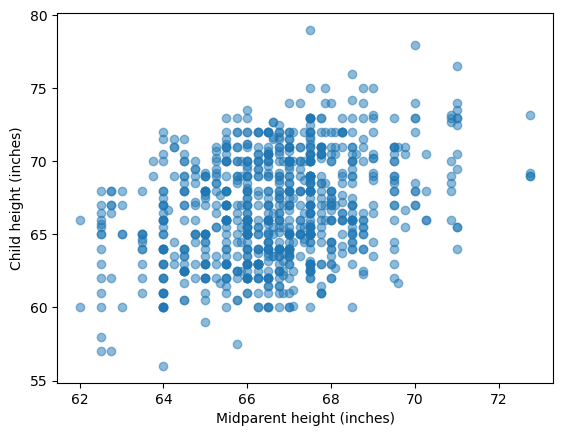

In [5]:
#Plot data
plt.scatter(midparent,d['height'],alpha=0.5) #Scatter plot of midparent vs child height
plt.xlabel("Midparent height (inches)") 
plt.ylabel("Child height (inches)")

In [6]:
# Galton's female height correction factor
father_mean = d.groupby('family')['father'].first().mean() # VERY IMPORTANT: groupby family to avoid counting same father/mother multiple times
mother_mean = d.groupby('family')['mother'].first().mean()
correction_factor = father_mean / mother_mean
print("Correction factor parents:", correction_factor)

boys_mean  = d[d["male"]==1.0]["height"].mean()
girls_mean = d[d["male"]==0.0]["height"].mean()
correction_factor_children = boys_mean / girls_mean
print("Correction factor children:", correction_factor_children)

Correction factor parents: 1.08384834469135
Correction factor children: 1.0798415634701515


69.3492385786802 69.233714922049
Parent mean: 1.76, Child mean: 1.76
Parent variance: 0.09, Child variance: 0.17


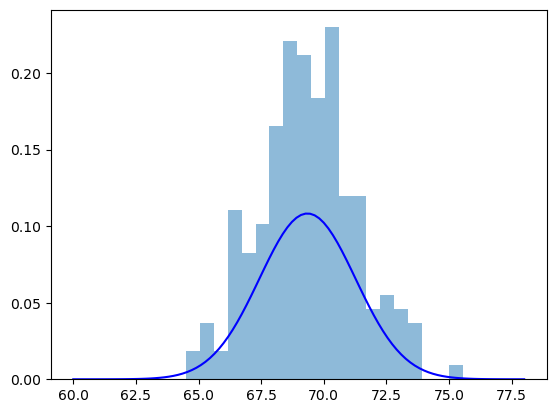

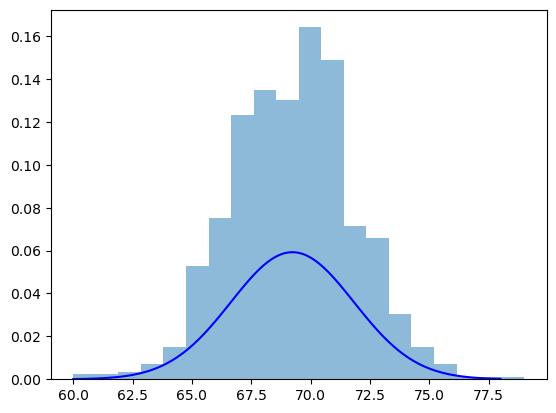

In [7]:
# Distribution of parents and children
midparent_transformed = (d.groupby('family')['father'].first() +d.groupby('family')['mother'].first() * correction_factor) / 2
d["mid_trans"] = (d['father'] +d['mother'] * correction_factor) / 2
d["height_trans"] = d['height'] *( d["female"]*correction_factor+d["male"])
height_transformed =  d["height"].to_numpy() * np.where(d["female"] == 1, 1.08, 1.0)
mu_p = midparent_transformed.mean()
mu_c = height_transformed.mean()
var_p = midparent_transformed.var()
var_c = height_transformed.var()
in_m = 0.0254 # inches to meters
print(mu_p,mu_c)
print(f"Parent mean: {mu_p*in_m:.2f}, Child mean: {mu_c*in_m:.2f}")
print(f"Parent variance: {var_p*in_m:.2f}, Child variance: {var_c*in_m:.2f}")

plt.hist(midparent_transformed, bins=20, alpha=0.5, label='Parents (transformed)',density=True)
hs = np.linspace(60,78,100)
rho_p = np.exp(-0.5*((hs - mu_p)/np.sqrt(var_p))**2) / (np.sqrt(2*np.pi*var_p**2.0))
plt.plot(hs, rho_p , 'b-', label='Parents (theoretical)')
plt.show();plt.close()



plt.hist(height_transformed , bins=20, alpha=0.5, label='Parents (transformed)',density=True)
hs = np.linspace(60,78,100)
rho_c = np.exp(-0.5*((hs - mu_c)/np.sqrt(var_c))**2) / (np.sqrt(2*np.pi*var_c**2.0))
plt.plot(hs, rho_c , 'b-', label='Children (theoretical)')
plt.show();plt.close()


In [10]:
# Probabilities of extreme heights in children (marginal and conditional)
extreme_height = 72.0 # inches
P_hp_gt_extreme = np.sum(midparent_transformed > extreme_height) / len(midparent_transformed)
P_hp_not_extreme = 1.0 - P_hp_gt_extreme
P_hc_gt_extreme = np.sum(height_transformed > extreme_height) / len(height_transformed)
extreme_mask = midparent_transformed > extreme_height  # length 898

print(f"P(hp > {extreme_height}) = {P_hp_gt_extreme:.3f}")
print(f"P(hp <= {extreme_height}) = {P_hp_not_extreme:.3f}")
print(f"P(hc > {extreme_height}) = {P_hc_gt_extreme:.3f}")

cond_parents_gt_extreme = d[d["mid_trans"]>extreme_height]["height_trans"].to_numpy()
p_hc_gt_extreme_with_parents_gt_extreme = np.sum(cond_parents_gt_extreme>extreme_height)/len(cond_parents_gt_extreme)

cond_parents_lt_extreme = d[d["mid_trans"]<=extreme_height]["height_trans"].to_numpy()
p_hc_gt_extreme_with_parents_lt_extreme = np.sum(cond_parents_lt_extreme>extreme_height)/len(cond_parents_lt_extreme)

print(f"P(hc > {extreme_height} | hp > {extreme_height}) = {p_hc_gt_extreme_with_parents_gt_extreme:.3f}")
print(f"P(hc > {extreme_height} | hp <= {extreme_height}) = {p_hc_gt_extreme_with_parents_lt_extreme:.3f}")


cond_children_gt_extreme = d[d["height_trans"]>extreme_height]["mid_trans"].to_numpy()
p_hp_gt_extreme_with_children_gt_extreme = np.sum(cond_children_gt_extreme>extreme_height)/len(cond_children_gt_extreme)

print(f"P(hp > {extreme_height} | hc > {extreme_height}) = {p_hp_gt_extreme_with_children_gt_extreme:.3f}")
print(f"P(hp < {extreme_height} | hc > {extreme_height}) = {1-p_hp_gt_extreme_with_children_gt_extreme:.3f}")

print("Prob. tall children have tall parents=", p_hc_gt_extreme_with_parents_gt_extreme*P_hp_gt_extreme / P_hc_gt_extreme)

P(hp > 72.0) = 0.091
P(hp <= 72.0) = 0.909
P(hc > 72.0) = 0.118
P(hc > 72.0 | hp > 72.0) = 0.556
P(hc > 72.0 | hp <= 72.0) = 0.101
P(hp > 72.0 | hc > 72.0) = 0.294
P(hp < 72.0 | hc > 72.0) = 0.706
Prob. tall children have tall parents= 0.4300354372186572
